In [86]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
#Fonction permettant d'échantilloner selon les lois
from numpy.random import dirichlet, normal, gamma
from scipy.stats import multivariate_normal as mult_norm, norm
from functools import partial
from progressbar import ProgressBar
import time
%matplotlib inline

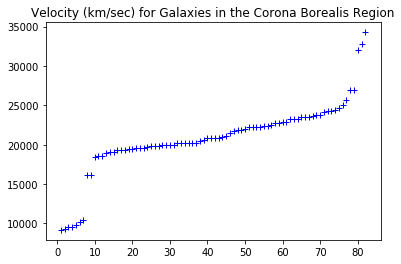

In [2]:
data = pd.read_csv('galaxy.csv', index_col=0)
y= data.iloc[:,0].values/1000
plt.plot(data.iloc[:,0],'b+', label="Velocity")
plt.title("Velocity (km/sec) for Galaxies in the Corona Borealis Region")
plt.show()

### Le but de cette étude est de trouver le nombre de clusters définissant la distribution des vitesses des étoiles dans la région de la [couronne boréale](https://fr.wikipedia.org/wiki/Couronne_bor%C3%A9ale)

Cet article propose d'estimer la distribution marginale $p(y)$ de la vraisemblance $L(y ;\theta)$. Pour celà, des estimateurs basés sur des échantillons obtenus par un échantilloneur de Gibbs sont utilisés. 
Dans notre exemple, on suppose que les données sont distribuées selon un modèle de mélange avec k groupes. Le modèle est défini comme suit. 
Priors du modèle
$$
\mu_j \sim \mathcal{N}(\mu_0 , phi)\\
\sigma_j \sim \mathcal{IG}(\frac{v_0}{2}, \frac{\delta_0}{2})\\
q \sim Dirichlet(\alpha_1, ..., \alpha_d)
$$
où d = nombre de clusters considérés (2 ou 3)

$\mu_0 = 20, \ A^{-1} = 100, \ v_0 = 6, \ \delta_0 = 40,\ \alpha_j = 1$

In [3]:
def normal_update(n_clust, clust_mean, sigma, sigma0=100,mu0=20,v0=6, delta0=40):
   
    ### Mean & var posterior de mu
    mu_mean_up = np.divide(n_clust*clust_mean* sigma0 + mu0 * sigma , sigma0 *n_clust + sigma )
    mu_var_up = np.divide(sigma0  * sigma, sigma0 * n_clust + sigma)

    return mu_mean_up, mu_var_up

def dirichlet_update(a, n_clust):
    return a + n_clust

def InvGamma_update(n_clust, delta, v0=6, delta0= 40):
        ### Paramètre de la loi posterieure de sigma
    v_up = v0 +n_clust
    delta_up = delta + delta0
    return v_up, delta_up

def z_update(q, mu, sigma, y, nb_clust=3):
    
    return np.array([ np.exp(np.log(q[i]) + 
                  np.log(mult_norm.pdf(x=y,mean=mu[i],cov=sigma[i]))) for i in range(nb_clust)]).T
                  


In [8]:
np.random.choice(np.array([[1,2,3],[4,5,6]]), p=np.array([1/3,1/3,1/3]))

ValueError: a must be 1-dimensional

In [41]:
#Initalisation des paramètres
nb_clust = 3
z=np.random.randint(0,nb_clust,size=(1,y.shape[0]))


clust ,n_clust = np.unique(z[-1], return_counts=True)

if(clust.shape[0] < nb_clust):
    print("ERROR - PAS ASSEZ DE CLUSTEURS LORS DE L'INITALISATION ALEATOIRE")
    
mu0= 20
A0 = 100
v0 = 6
delta0 = 40
alpha = np.ones(nb_clust)
sigma0 = 1

q0 = np.ones(nb_clust)

#Calcul des quantités nécessaires pour la mise à jour des paramètres : moyenne intra clust et mse intra clust
delta, clust_mean= [],[]
for i in range(nb_clust):
    delta.append(np.sum(np.square(y[z[-1]==i]-mu0)))
    clust_mean.append(np.mean(y[z[-1]==i]))
delta, clust_mean = np.array(delta), np.array(clust_mean)

#Mise à jour de la moyenne mu
mu_mean_up, mu_var_up = normal_update(n_clust, clust_mean, sigma=sigma0)
mu_sample = normal(loc = mu_mean_up, scale = mu_var_up)
y_mse = [np.sum(np.square( y[z[-1]==i] - mu_mean_up[i] )) for i in range(nb_clust)]

#Mise à jour de la variance sigma
v_up, delta_up = InvGamma_update(n_clust, delta)
sigma_sample = 1/gamma(v_up, 1/delta_up) # Est-ce correcte ou faut-il inverser le deuxième paramètre ? 

#Mise à jour des probas de chaque cluster
q_up = z_update(q0, mu_sample, sigma_sample,y)
q_up = q_up/q_up.sum(axis=1, keepdims=True)
z_sample= np.array([np.random.choice(range(nb_clust), p=q_up[i]) for i in range(y.shape[0])])

mu_sample = mu_sample.reshape(1, mu_sample.shape[0])
sigma_sample = sigma_sample.reshape(1, sigma_sample.shape[0])
z_sample = z_sample.reshape(1, z_sample.shape[0])

In [43]:
print(mu_sample)
print(sigma_sample)
print(z_sample)

[[21.12788153 20.51156821 20.89593874]]
[[15.89825786 25.86313106 15.03644753]]
[[1 1 2 1 2 2 1 1 0 0 1 0 2 0 2 0 0 0 1 1 2 0 2 2 0 0 2 1 2 2 1 0 0 0 0 1
  2 2 1 2 1 1 1 2 1 2 0 1 0 2 0 0 0 2 2 0 0 1 0 2 0 2 1 0 0 0 1 2 0 0 2 2
  1 1 1 1 0 0 2 2 0 0]]


In [56]:
k=1
#Calcul des quantités nécessaires pour la mise à jour des paramètres : moyenne intra clust et mse intra clust
delta, clust_mean= [],[]
for i in range(nb_clust):
    delta.append(np.sum(np.square(y[z_sample[-1]==i]-mu_sample[-1][i])))
    clust_mean.append(np.mean(y[z_sample[-1]==i]))
delta, clust_mean = np.nan_to_num(delta), np.nan_to_num(clust_mean)

C:\Users\remib\Anaconda3\envs\ML\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\remib\Anaconda3\envs\ML\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [57]:
print(delta)
print(clust_mean)

[   0.        2130.3593046    0.       ]
[ 0.        20.8314878  0.       ]


In [50]:
#Mise à jour de la moyenne mu
#print(clust_mean)
mu_mean_up, mu_var_up = normal_update(n_clust, clust_mean, sigma=sigma_sample[-1][i])
#print(mu_mean_up, mu_var_up)
mu_sample = np.vstack((mu_sample, normal(loc = mu_mean_up, scale = mu_var_up)))
y_mse = [np.sum(np.square( y[z[-1]==i] - mu_mean_up[i] )) for i in range(nb_clust)]

print(mu_mean_up)
print(mu_sample)
print(y_mse)

[22.12437049 19.42613208 20.52092392]
[[21.12788153 20.51156821 20.89593874]
 [22.53414856 18.51492782 21.99199679]]
[531.5767305269496, 846.8131955219842, 369.4779989264341]


In [51]:
#Mise à jour de la variance sigma
v_up, delta_up = InvGamma_update(n_clust, delta)
sigma_sample = np.vstack((sigma_sample, 1/gamma(v_up, 1/delta_up))) # Est-ce correcte ou faut-il inverser le deuxième paramètre ? 

print(v_up)
print(delta_up)
print(sigma_sample)

[32 41 27]
[507.78162914 632.60786985 629.94807408]
[[15.89825786 25.86313106 15.03644753]
 [26.29503352 13.09705671 20.13816376]]


In [52]:
#Mise à jour des probas de chaque cluster
q_tmp= z_update(q_up[-1], mu_sample[-1], sigma_sample[-1],y)
q_tmp = np.nan_to_num(q_tmp)
q_up = np.vstack((q_up, np.divide(q_tmp,q_tmp.sum(axis=1, keepdims=True))))
print(q_tmp)
print(q_up)


[[4.18175889e-04 2.91822056e-03 1.47702312e-04]
 [4.57488878e-04 3.30931985e-03 1.65294271e-04]
 [4.88872394e-04 3.62965206e-03 1.79608710e-04]
 [5.07359424e-04 3.82150064e-03 1.88147813e-04]
 [5.64200713e-04 4.42490724e-03 2.14871899e-04]
 [6.99838325e-04 5.93625425e-03 2.81231819e-04]
 [7.60532912e-04 6.64010536e-03 3.11985927e-04]
 [5.65256837e-03 6.52230490e-02 3.67457681e-03]
 [5.77226823e-03 6.62538061e-02 3.76777421e-03]
 [9.03593512e-03 8.17006781e-02 6.36677999e-03]
 [9.22288080e-03 8.17250971e-02 6.51594382e-03]
 [9.28976078e-03 8.17068069e-02 6.56921415e-03]
 [9.73574209e-03 8.12012875e-02 6.92278387e-03]
 [9.90118291e-03 8.08343278e-02 7.05301257e-03]
 [9.92475107e-03 8.07736847e-02 7.07151427e-03]
 [1.02573973e-02 7.96826061e-02 7.33107072e-03]
 [1.02736259e-02 7.96176527e-02 7.34364864e-03]
 [1.02811024e-02 7.95873457e-02 7.34944031e-03]
 [1.03934205e-02 7.91024405e-02 7.43621281e-03]
 [1.04336419e-02 7.89149978e-02 7.46717356e-03]
 [1.05012576e-02 7.85829754e-02 7.519077

In [53]:
print(q_up[0])

[0.12814795 0.74960734 0.12224471]


In [54]:
z_sample= np.array([np.random.choice(range(nb_clust), p=q_up[i]) for i in range(y.shape[0])])

In [55]:
print(z_sample)

[1 0 1 1 1 1 1 0 1 0 1 0 0 0 0 2 2 1 1 2 2 0 2 0 1 0 2 2 2 2 2 0 1 1 2 1 1
 0 1 2 2 2 1 0 2 1 2 2 0 0 1 0 0 0 1 0 0 2 1 1 2 1 0 2 0 0 0 2 1 1 0 2 2 0
 0 0 0 1 2 2 1 1]


In [58]:
n_iter = 1000
bar = ProgressBar(maxval=n_iter)
bar.start()
for k in range(n_iter):
        #Calcul des quantités nécessaires pour la mise à jour des paramètres : moyenne intra clust et mse intra clust
    delta, clust_mean= [],[]
    for i in range(nb_clust):
        delta.append(np.sum(np.square(y[z_sample[-1]==i]-mu_sample[-1][i])))
        clust_mean.append(np.mean(y[z_sample[-1]==i]))
    delta, clust_mean = np.nan_to_num(delta), np.nan_to_num(clust_mean)

    #Mise à jour de la moyenne mu
    mu_mean_up, mu_var_up = normal_update(n_clust, clust_mean, sigma=sigma_sample[-1][i])
    mu_sample = np.vstack((mu_sample, normal(loc = mu_mean_up, scale = mu_var_up)))
    y_mse = [np.sum(np.square( y[z[-1]==i] - mu_mean_up[i] )) for i in range(nb_clust)]

    #Mise à jour de la variance sigma
    v_up, delta_up = InvGamma_update(n_clust, delta)
    sigma_sample = np.vstack((sigma_sample, 1/gamma(v_up, 1/delta_up))) # Est-ce correcte ou faut-il inverser le deuxième paramètre ? 

    #Mise à jour des probas de chaque cluster
    q_tmp= z_update(q_up[-1], mu_sample[-1], sigma_sample[-1],y)
    q_tmp = np.nan_to_num(q_tmp)
    q_up = np.vstack((q_up, np.divide(q_tmp,q_tmp.sum(axis=1, keepdims=True))))
    z_sample= np.vstack((z,np.array([np.random.choice(range(nb_clust), p=q_up[i]) for i in range(y.shape[0])])))
    bar.update(k)
bar.finish()

N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--C:\Users\remib\Anaconda3\envs\ML\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\remib\Anaconda3\envs\ML\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  2% (26 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:06

[[1.28147950e-001 7.49607342e-001 1.22244708e-001]
 [1.33463216e-001 7.38600208e-001 1.27936576e-001]
 [1.37471232e-001 7.30279679e-001 1.32249089e-001]
 [1.39743512e-001 7.25554786e-001 1.34701702e-001]
 [1.46359741e-001 7.11766079e-001 1.41874180e-001]
 [1.60277224e-001 6.82614216e-001 1.57108560e-001]
 [1.65812773e-001 6.70965933e-001 1.63221294e-001]
 [3.07280641e-001 3.67081997e-001 3.25637362e-001]
 [3.08662516e-001 3.64162454e-001 3.27175030e-001]
 [3.37433054e-001 3.06185088e-001 3.56381857e-001]
 [3.38732733e-001 3.03793335e-001 3.57473932e-001]
 [3.39191847e-001 3.02956657e-001 3.57851496e-001]
 [3.42181949e-001 2.97625764e-001 3.60192287e-001]
 [3.43262722e-001 2.95755681e-001 3.60981597e-001]
 [3.43415566e-001 2.95493935e-001 3.61090499e-001]
 [3.45546126e-001 2.91922894e-001 3.62530980e-001]
 [3.45648900e-001 2.91754565e-001 3.62596535e-001]
 [3.45696215e-001 2.91677201e-001 3.62626584e-001]
 [3.46404605e-001 2.90529034e-001 3.63066361e-001]
 [3.46657236e-001 2.90124306e-0

  3% (38 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:06C:\Users\remib\Anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
  6% (64 of 1000) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:05

[[1.28147950e-001 7.49607342e-001 1.22244708e-001]
 [1.33463216e-001 7.38600208e-001 1.27936576e-001]
 [1.37471232e-001 7.30279679e-001 1.32249089e-001]
 ...
 [1.29694069e-215 1.00000000e+000 4.16642177e-296]
 [1.26522690e-215 1.00000000e+000 3.66009437e-296]
 [1.17089279e-215 1.00000000e+000 2.73514036e-296]]
[[1.28147950e-001 7.49607342e-001 1.22244708e-001]
 [1.33463216e-001 7.38600208e-001 1.27936576e-001]
 [1.37471232e-001 7.30279679e-001 1.32249089e-001]
 ...
 [4.51362643e-221 1.00000000e+000 6.68059420e-297]
 [6.70674093e-222 1.00000000e+000 4.93808424e-297]
 [8.92746359e-224 1.00000000e+000 2.46937033e-297]]
[[1.28147950e-001 7.49607342e-001 1.22244708e-001]
 [1.33463216e-001 7.38600208e-001 1.27936576e-001]
 [1.37471232e-001 7.30279679e-001 1.32249089e-001]
 ...
 [1.30043899e-224 1.00000000e+000 4.26488571e-297]
 [9.85111569e-225 1.00000000e+000 4.66286737e-297]
 [5.27426398e-225 1.00000000e+000 5.70499316e-297]]
[[1.28147950e-001 7.49607342e-001 1.22244708e-001]
 [1.33463216e

 10% (102 of 1000) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:04

[[1.28147950e-001 7.49607342e-001 1.22244708e-001]
 [1.33463216e-001 7.38600208e-001 1.27936576e-001]
 [1.37471232e-001 7.30279679e-001 1.32249089e-001]
 ...
 [4.27778962e-295 1.00000000e+000 0.00000000e+000]
 [3.10608902e-295 1.00000000e+000 0.00000000e+000]
 [1.53093260e-295 1.00000000e+000 0.00000000e+000]]
[[1.28147950e-001 7.49607342e-001 1.22244708e-001]
 [1.33463216e-001 7.38600208e-001 1.27936576e-001]
 [1.37471232e-001 7.30279679e-001 1.32249089e-001]
 ...
 [3.17782288e-296 1.00000000e+000 0.00000000e+000]
 [2.09917933e-296 1.00000000e+000 0.00000000e+000]
 [8.01670944e-297 1.00000000e+000 0.00000000e+000]]
[[1.28147950e-001 7.49607342e-001 1.22244708e-001]
 [1.33463216e-001 7.38600208e-001 1.27936576e-001]
 [1.37471232e-001 7.30279679e-001 1.32249089e-001]
 ...
 [2.04486466e-300 1.00000000e+000 0.00000000e+000]
 [5.14921544e-301 1.00000000e+000 0.00000000e+000]
 [2.22475022e-302 1.00000000e+000 0.00000000e+000]]
[[1.28147950e-001 7.49607342e-001 1.22244708e-001]
 [1.33463216e

 15% (152 of 1000) |###                  | Elapsed Time: 0:00:00 ETA:   0:00:04

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 17% (178 of 1000) |###                  | Elapsed Time: 0:00:00 ETA:   0:00:04

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 22% (228 of 1000) |####                 | Elapsed Time: 0:00:01 ETA:   0:00:03


[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ..

 26% (266 of 1000) |#####                | Elapsed Time: 0:00:01 ETA:   0:00:03

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 30% (304 of 1000) |######               | Elapsed Time: 0:00:01 ETA:   0:00:03


[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ..

 34% (342 of 1000) |#######              | Elapsed Time: 0:00:01 ETA:   0:00:03


[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ..

 38% (380 of 1000) |#######              | Elapsed Time: 0:00:01 ETA:   0:00:03

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 41% (418 of 1000) |########             | Elapsed Time: 0:00:02 ETA:   0:00:02

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 44% (444 of 1000) |#########            | Elapsed Time: 0:00:02 ETA:   0:00:02

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 48% (482 of 1000) |##########           | Elapsed Time: 0:00:02 ETA:   0:00:02

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 53% (532 of 1000) |###########          | Elapsed Time: 0:00:02 ETA:   0:00:02

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 56% (570 of 1000) |###########          | Elapsed Time: 0:00:02 ETA:   0:00:02

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 58% (583 of 1000) |############         | Elapsed Time: 0:00:02 ETA:   0:00:02

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 60% (608 of 1000) |############         | Elapsed Time: 0:00:03 ETA:   0:00:02

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 64% (646 of 1000) |#############        | Elapsed Time: 0:00:03 ETA:   0:00:01

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 67% (671 of 1000) |##############       | Elapsed Time: 0:00:03 ETA:   0:00:01

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 69% (695 of 1000) |##############       | Elapsed Time: 0:00:03 ETA:   0:00:01

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 70% (707 of 1000) |##############       | Elapsed Time: 0:00:03 ETA:   0:00:01

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 73% (732 of 1000) |###############      | Elapsed Time: 0:00:04 ETA:   0:00:01


[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ..

 75% (756 of 1000) |###############      | Elapsed Time: 0:00:04 ETA:   0:00:01

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 77% (779 of 1000) |################     | Elapsed Time: 0:00:04 ETA:   0:00:01

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 79% (798 of 1000) |################     | Elapsed Time: 0:00:04 ETA:   0:00:01

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 82% (821 of 1000) |#################    | Elapsed Time: 0:00:04 ETA:   0:00:01


[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ..

 84% (845 of 1000) |#################    | Elapsed Time: 0:00:05 ETA:   0:00:01


[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ..

 86% (868 of 1000) |##################   | Elapsed Time: 0:00:05 ETA:   0:00:01

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 88% (885 of 1000) |##################   | Elapsed Time: 0:00:05 ETA:   0:00:01

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 90% (908 of 1000) |###################  | Elapsed Time: 0:00:05 ETA:   0:00:00


[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ..

 91% (919 of 1000) |###################  | Elapsed Time: 0:00:05 ETA:   0:00:00

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 95% (950 of 1000) |###################  | Elapsed Time: 0:00:06 ETA:   0:00:00

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

 96% (961 of 1000) |#################### | Elapsed Time: 0:00:06 ETA:   0:00:00

[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

100% (1000 of 1000) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]
[[0.12814795 0.74960734 0.12224471]
 [0.13346322 0.73860021 0.12793658]
 [0.13747123 0.73027968 0.13224909]
 ...

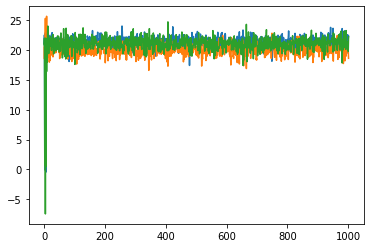

In [59]:
plt.plot(mu_sample)

In [83]:
norm.pdf([1,2,3])

array([0.24197072, 0.05399097, 0.00443185])

In [114]:
np.array([1,2,3])*np.ones((82,3))

array([[1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2

In [135]:
f= partial(norm.pdf, y)

def Log_likelihood(q, mu, sigma):
    #Prend un seul y, calcul la densité pour chaque cluster et pondère par la proba du cluster
    #INPUT : q = dimension 3, proba de chaque cluster
    #       mu = dimension 3, moyenne de chaque cluster
    #    sigma = dimension 3, var de chaque cluster
    return np.log(list(map(lambda i: np.exp(np.log(q)+np.log(list(map(norm.pdf,y[i]*np.ones(3), mu, np.sqrt(sigma))))).sum(), range(y.shape[0])))).sum()

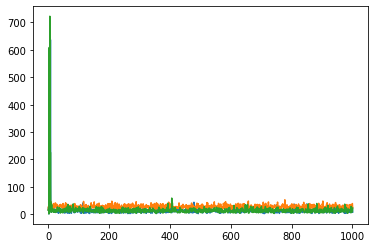

In [132]:
plt.plot(sigma_sample)

In [136]:
a = Log_likelihood(q_up[0],mu_sample[0],sigma_sample[0])
a

-239.71624924856545

In [ ]:
## Pour obtenir l'estimateur posterieur de la valeur de l'ordonnée de Chib , 
#on peut utiliser la décomposition du papier

